In [1]:
#%pip install geatpy==2.7.0

In [2]:
#%pip install baostock

In [27]:
import geatpy as ea
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import baostock as bs

In [10]:


bs.login()

huaxia_stock = bs.query_history_k_data_plus("sz.002928",
"date,close",
start_date='2019-07-01', end_date='2023-07-31',
frequency="d", adjustflag="3")

chunqiu_stock = bs.query_history_k_data_plus("sh.601021",
"date,close",
start_date='2019-07-01', end_date='2023-07-31',
frequency="d", adjustflag="3")

jixiang_stock = bs.query_history_k_data_plus("sh.603885",
"date,close",
start_date='2019-07-01', end_date='2023-07-31',
frequency="d", adjustflag="3")

zhguo_stock = bs.query_history_k_data_plus("sh.601111",
"date,close",
start_date='2019-07-01', end_date='2023-07-31',
frequency="d", adjustflag="3")

login success!


In [11]:
# 转成DataFrame
huaxia_stock_df = huaxia_stock.get_data().set_index('date') 
chunqiu_stock_df = chunqiu_stock.get_data().set_index('date')
jixiang_stock_df = jixiang_stock.get_data().set_index('date')
zhguo_stock_df = zhguo_stock.get_data().set_index('date')


In [61]:
# 合并数据
stock_df = pd.DataFrame()
#stock_df['huaxia'] = huaxia_stock_df['close']
stock_df['chunqiu'] = chunqiu_stock_df['close']
stock_df['jixiang'] = jixiang_stock_df['close']
stock_df['zhguo'] = zhguo_stock_df['close']
stock_df['date'] = huaxia_stock_df.index
stock_df = stock_df.set_index('date').dropna()
stock_df = stock_df.astype('float')
#stock_df.to_excel('stock.xlsx')

<Figure size 1600x900 with 0 Axes>

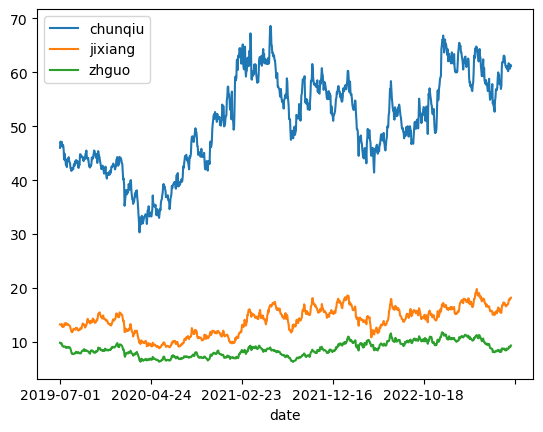

<Axes: >

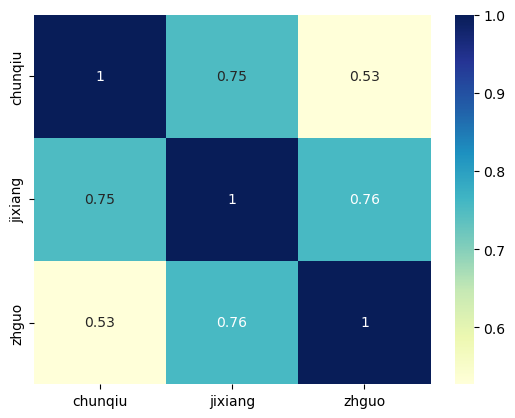

In [46]:
plt.figure(figsize=(16, 9))
stock_df[['chunqiu','jixiang','zhguo']].astype('float').plot()
plt.show()
sns.heatmap(stock_df.corr(), annot=True, cmap='YlGnBu')

In [59]:
from statsmodels.tsa.stattools import adfuller
# 单位根检验
def adf_test(x):
    result = adfuller(x)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] <= 0.01:
        print('在99%置信水平下平稳')

In [146]:
# 实现多元协整方程
import statsmodels.api as sm
# 从df转np  用于OLS
x = np.array(stock_df[['chunqiu','jixiang','zhguo']])
x = x.astype(np.float64)

def cointegration(x,w):
    w = w / np.sum(w)
    y = np.dot(x,w)
    # 每一项都改为xt/x0，xt是当前的值，x0是第一个值,再取对数
    y = np.log(y / y[0])[1:]
    # x是多列
    x = np.log(x / x[0])[1:,:]
    model = sm.OLS(y, x).fit()
    # 残差
    e = y - np.dot(x, model.params)
    adf_test(e)
    print(f'params:{model.params}')
    print(model.summary())
    

cointegration(x, np.array([1,1,1]))


ADF Statistic: -3.994410
p-value: 0.001440
在99%置信水平下平稳


In [174]:
def trading(index):
    stock_df = pd.read_excel('stock.xlsx')
    stock_df = stock_df.set_index('date').dropna()
    window=round(index[0]) # MA的滚动窗口
    # 计算价差
    bond_large, bond_small = (index[1], index[2]) if (index[1] > index[2]) else (index[2], index[1])
    stock_df['spread'] = stock_df[['chunqiu','jixiang','zhguo']].apply(lambda x: sum([x[i]*index[3+i] for i in range(0, len(x))]), axis=1)
    stock_df['MA'] = stock_df['spread'].rolling(window=window).mean()
    stock_df.dropna(inplace=True, axis=0) # 对每一行进行操作，所以axis=0
    std = np.std(stock_df['spread'])
    # 计算上下轨
    stock_df['up_open'] = stock_df['MA'] + bond_large * std
    stock_df['down_open'] = stock_df['MA'] - bond_large * std
    stock_df['up_close'] = stock_df['MA'] + bond_small * std
    stock_df['down_close'] = stock_df['MA'] - bond_small * std
    position = 0
    cumu_return_rate = 1
    return_rate_list = []
    last_hold = 0
    hold = False
    for i in range(len(stock_df)):
        # 如果价差接近正上轨，做空价差，在正下轨平仓
        # 如果价差接近负上轨，做多价差，在负下轨平仓
        # 计算每次的收益率，累计收益率
        if not hold:
            if stock_df['spread'][i] >= stock_df['up_open'][i]:
                hold = True
                position = -1
                last_hold = i
            elif stock_df['spread'][i] <= stock_df['down_open'][i]:
                hold = True
                position = 1 # 做多
                last_hold = i
        else:
            # 如果价差回归均值，平仓
            if stock_df['spread'][i] <= stock_df['up_close'][i] and position == -1 and stock_df['spread'][i] >= 0:
                hold = False
                return_rate = abs((-stock_df['spread'][i] + stock_df['spread'][last_hold]) / stock_df['spread'][last_hold])
                # if return_rate > 1:
                #     print(stock_df['spread'][i], stock_df['spread'][last_hold])
                return_rate_list.append(return_rate)
                cumu_return_rate = cumu_return_rate * (1 + return_rate)
            elif stock_df['spread'][i] >= stock_df['down_close'][i] and position == 1 and stock_df['spread'][i] <= 0:
                hold = False
                return_rate = abs((-stock_df['spread'][last_hold] + stock_df['spread'][i]) / stock_df['spread'][last_hold])
                # if return_rate > 1:
                #     print(stock_df['spread'][i], stock_df['spread'][last_hold])
                return_rate_list.append(return_rate)
                cumu_return_rate = cumu_return_rate * (1 + return_rate)
            # # 对于突然的大幅波动，平仓
            # elif stock_df['spread'][i] <= 0 and position == -1:
            #     hold = False
            #     return_rate = (stock_df['spread'][i] - stock_df['spread'][last_hold]) / stock_df['spread'][last_hold]
            #     # if return_rate > 1:
            #     #     print(stock_df['spread'][i], stock_df['spread'][last_hold])
            #     return_rate_list.append(return_rate)
            #     cumu_return_rate = cumu_return_rate * (1 + return_rate)
            # elif stock_df['spread'][i] >= 0 and position == 1:
            #     hold = False
            #     return_rate = (stock_df['spread'][last_hold] - stock_df['spread'][i]) / stock_df['spread'][last_hold]
            #     # if return_rate > 1:
            #     #     print(stock_df['spread'][i], stock_df['spread'][last_hold])
            #     return_rate_list.append(return_rate)
            #     cumu_return_rate = cumu_return_rate * (1 + return_rate)
            elif i == len(stock_df) - 1 and position != 0:
                hold = False
                return_rate = (stock_df['spread'][i] - stock_df['spread'][last_hold]) / abs(stock_df['spread'][last_hold])
                # if return_rate > 1:
                #     print(stock_df['spread'][i], stock_df['spread'][last_hold])
                return_rate_list.append(return_rate)
                cumu_return_rate = cumu_return_rate * (1 + return_rate)
    if len(return_rate_list) == 0:
        return 0, None
    if abs(bond_large - bond_small) <= 1e-3:
        return 0, None
    if all([i > 0 for i in index[3:]]): # 所有参数都大于0,说明组合全是做多，风险太大
        return 0, None
    if all([i < 0 for i in index[3:]]): # 所有参数都小于0,说明组合全是做空，风险太大
        return 0, None
    # plt.plot(return_rate_list)
    # 画出spread和上下轨
    # plt.plot(stock_df['spread'])
    # plt.plot(stock_df['up_open'], color='red')
    # plt.plot(stock_df['down_open'], color='red')
    # plt.plot(stock_df['up_close'],  color='green')
    # plt.plot(stock_df['down_close'],    color='green')
    #print((cumu_return_rate)**(1/6), cumu_return_rate)
    return abs(cumu_return_rate)**(1/6)*(-1 if cumu_return_rate <0 else 1), np.mean(return_rate_list)/np.std(return_rate_list)
        
    

In [167]:

# 自定义问题类，多参数的优化问题
class MyProblem(ea.Problem): # 继承Problem父类
    def __init__(self):
        name = 'PairTrading' # 初始化name（函数名称，可以随意设置）
        Dim = 6 # 初始化Dim（决策变量维数）
        maxormins = [-1] # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        
        M = 1 # 初始化M（目标维数）
        varTypes = [1, 0, 0, 0, 0, 0] # 除了第一个是代表布林带均值计算的MA的n值，其余都是0，代表连续变量
        lb = [1, 0.5, 0.5, -10, -10, -10] # 决策变量下界
        ub = [20, 3, 3, 10, 10, 10] # MA的n值上界为10，布林带上下标准差数量上界为3
        #ReconbinOpt = 'xovdp'
        #borders = np.array([[1] * Dim,[1]*Dim]) # 生成区域描述器，这里是两个长度为Dim的列表，列表中的元素都是1
        #mutStyle = 'mutg'  # 使用高斯变异
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub)

    def aimFunc(self, pop):
        vars = pop.Phen
        ObjV = np.zeros((vars.shape[0], 1))
        # 对每一个个体进行循环，计算目标函数值
        for i in range(vars.shape[0]): # vars.shape[0]表示行数
            # 计算目标函数值
            #print(vars[i,:])
            #print(trading(vars[i,:]))

            ObjV[i, 0] = trading(vars[i,:])[0] # Phen[[i],:]是二维数组，Phen[i,:]是一维数组
        pop.ObjV = ObjV

In [169]:
# 实例化问题对象
problem = MyProblem()
# 实例化种群对象（此时种群还没被初始化，仅仅是完成了种群对象的实例化）
Encoding = 'RI'       # 编码方式,这里是实数编码 
NIND = 50             # 种群规模

# Define ranges and borders
ranges = np.vstack([problem.lb, problem.ub])

# Create field
Field = ea.crtfld(Encoding, problem.varTypes, ranges, problem.borders)

# Create population
population = ea.Population(Encoding, Field, NIND)

# Create algorithm
algorithm = ea.soea_SEGA_templet(problem, population, MAXGEN=50, FINITPOP=50)

# Set mutation probability
algorithm.mutOper.Pm = 0.005
algorithm.recOper.XOVR = 0.7


In [ ]:
# 运行
[bestid, pop] = algorithm.run() # 执行算法模板，得到最后一代种群以及进化记录器

In [171]:
print('评价次数：%s' % algorithm.evalsNum)
print('时间已过 %s 秒' % algorithm.passTime)
if bestid.sizes != 0:
    print('最优的目标函数值为：%s' %bestid.ObjV[0][0])
    print('最优的控制变量值为：')
    for i in range(bestid.Phen.shape[1]):
        print(bestid.Phen[0, i])
else:
    print('没找到可行解。')


评价次数：2500
时间已过 1081.7661774158478 秒
最优的目标函数值为：1.3525008019791482
最优的控制变量值为：
17.0
0.58697509765625
0.7501678466796875
-4.769725799560547
9.318866729736328
10.0


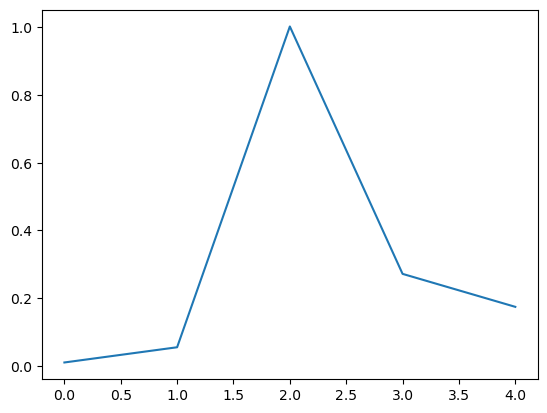

In [175]:
cumu, sharpe = trading(bestid.Phen[0,:])
bestid.save()

In [173]:
print(sharpe)

0.5090387868433308
